# Costa Rica Pipeline Notebook

This is the `Predictor Acquisition / Cleaning and EDA` section of the notebook where:

- Acquisition of data from Google Earth Engine (`predictor values`)
- An EDA using the `acquired/transformed data` from GEE focused on:
    1. Dealing with NA values by substituting them with the mean of the column
- Data Reduction Techniques are implemented on our `transformed data` (e.g. `PCA, CCA, factor analysis, etc.`) (**`TODO`**)

## Section 1 - Setup

### Section 1.1 - Installing software and importing packages

In [61]:
!pip install pandas numpy geopandas seaborn scikit-learn tensor folium matplotlib mapclassify earthengine-api geemap pyarrow

In [62]:
from IPython.core.display import display_webp
from geopandas import GeoDataFrame
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
import geemap
import ee
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow

### Section 1.2 - Importing our Dataset

In [63]:
# We are importing the observational data from the ZIP file provided (which contains the shape file) into a GeoDataFrame
gdf_s = gpd.read_parquet('../Costa_Rica_Data/Data Acquisition Output/classification_data/sp_clean_classification_data.parquet')
gdf_e = gpd.read_parquet('../Costa_Rica_Data/Data Acquisition Output/classification_data/en_clean_classification_data.parquet')

# These display information about the GeoDataFrame to confirm the contains are what we expected
display(gdf_s.columns)
display(gdf_e.columns)

# Confirming that these are GeoDataFrames
display(type(gdf_s))
display(type(gdf_e))

# Confirming the shape of the GeoDataFrames
display(gdf_s.shape)
display(gdf_e.shape)

Index(['plotid', 'sampleid', 'Uso', 'Cobertura', 'Vegetacion', 'Herbaceas',
       'Pasto_Arb', 'Cultivo', 'Humedal', 'Terreno', 'Agua', 'Otra_clase',
       'SAF', 'Cambios15_', 'Gana_Perdi', 'geometry'],
      dtype='object')

Index(['plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous',
       'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType',
       'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss',
       'geometry'],
      dtype='object')

geopandas.geodataframe.GeoDataFrame

geopandas.geodataframe.GeoDataFrame

(91917, 16)

(91917, 16)

## Section 2 Continued - EDA of Predictor Values

### Section 2.3 - Acquisition and Transformation of data from GEE

#### Section 2.3.1 - Acquisition of predictor values with GEE/Planetary Computer code to extract the pixel values under plots

In [64]:
# The output of John's Code (English version)
gdf_predictors = gpd.read_parquet('../Costa_Rica_Data/Data Acquisition Output/extracted_gee_data/en_basic_gee_data.parquet')
# The output of John's Code (Spanish version)
gdf_predictors_sp = gpd.read_parquet('../Costa_Rica_Data/Data Acquisition Output/extracted_gee_data/sp_basic_gee_data.parquet')

# Confirming the columns of the GeoDataFrame and it's type
display(gdf_predictors.columns)
display(type(gdf_predictors))
display(gdf_predictors.shape)

Index(['plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous',
       'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType',
       'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss',
       'geometry', 'BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2',
       'aspect', 'aspectcos', 'aspectdeg', 'aspectsin', 'brightness',
       'clay_1mMed', 'diff', 'elevation', 'evi', 'fpar', 'hand30_100', 'lai',
       'mTPI', 'ndvi', 'ocs_1mMed', 'sand_1mMed', 'savi', 'silt_1mMed',
       'slope', 'topDiv', 'wetness'],
      dtype='object')

geopandas.geodataframe.GeoDataFrame

(91917, 44)

#### Section 2.3.2 - EDA on this dataset of predictors

In [65]:
# Prints the NA count for column with NA values
na_count = gdf_predictors.isna().sum()
print(na_count[na_count > 0])

BLUE            30
GREEN           26
NIR             26
RED             26
SWIR1           26
SWIR2           26
altura2       3527
brightness      26
diff            26
evi             30
hand30_100       3
mTPI           157
ndvi           339
savi            26
topDiv         157
wetness         26
dtype: int64


Based on our understanding of the dataset, the classification columns contained NA values.

Therefore, using the `fillna` function, we replace all of those with "Not_Applicable".

---

One other thing we notice, is the predictor columns (i.e. BLUE -> wetness) all contain some level of NA values.

Therefore, we should find a way to replace those too.

In [66]:
# Filling all the numeric values that are missing with the mean from the column
columns_to_fill = ['BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'brightness', 'diff', 'evi', 'hand30_100','mTPI', 'ndvi', 'savi', 'topDiv','wetness']  # Specify the columns to fill
for column in columns_to_fill:
    gdf_predictors[column] = gdf_predictors[column].fillna(gdf_predictors[column].mean())
    gdf_predictors_sp[column] = gdf_predictors_sp[column].fillna(gdf_predictors_sp[column].mean())

In [67]:
#print(gdf.dtypes)
na_count = gdf_predictors.isna().sum()
print(na_count)

plotid            0
sampleid          0
Use               0
CoverType         0
Vegetations       0
Herbaceous        0
GrasslandShrub    0
CropsType         0
WetlandArea       0
LandType          0
WaterBodyType     0
OtherClass        0
SAF               0
Changes_15        0
Gain_Loss         0
geometry          0
BLUE              0
GREEN             0
NIR               0
RED               0
SWIR1             0
SWIR2             0
altura2           0
aspect            0
aspectcos         0
aspectdeg         0
aspectsin         0
brightness        0
clay_1mMed        0
diff              0
elevation         0
evi               0
fpar              0
hand30_100        0
lai               0
mTPI              0
ndvi              0
ocs_1mMed         0
sand_1mMed        0
savi              0
silt_1mMed        0
slope             0
topDiv            0
wetness           0
dtype: int64


After replacing the NA values with the mean of the column, we are left with a dataset that has no NA values.

In [68]:
display(gdf_predictors.head(10))
display(gdf_predictors['Use'].unique())
display(gdf_predictors['CoverType'].unique())

,plotid,sampleid,Use,CoverType,Vegetations,Herbaceous,GrasslandShrub,CropsType,WetlandArea,LandType,...,lai,mTPI,ndvi,ocs_1mMed,sand_1mMed,savi,silt_1mMed,slope,topDiv,wetness
9,2902,11605,Wetlands,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,0.305,8129.0,0.799771,68.0,332.15,0.393728,298.85,0.927410,1323.685053,-0.006312
12,2902,11608,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),Not_Applicable,Not_Applicable,Not_Applicable,...,0.305,8129.0,0.796553,68.0,332.15,0.423713,298.85,2.935819,1323.685053,-0.014932
13,2902,11609,Wetlands,Vegetation,Herbaceous plants,Grasses,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,0.260,8129.0,0.644415,65.0,340.45,0.380250,304.70,0.944368,1323.685053,-0.001697
15,2902,11611,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),Not_Applicable,Not_Applicable,Not_Applicable,...,0.305,8129.0,0.784331,68.0,332.15,0.512687,298.85,0.927410,1323.685053,-0.027987
16,2902,11612,Wetlands,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,0.260,8129.0,0.769357,65.0,340.45,0.360428,304.70,2.645556,1323.685053,-0.009912
18,2903,11609,Other classes,No vegetation,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Other surfaces,...,0.270,8132.0,0.528579,63.0,336.45,0.295504,265.70,7.437723,1323.698838,-0.032052
19,2903,11610,Other classes,No vegetation,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Other surfaces,...,0.270,8132.0,0.437536,63.0,336.45,0.152839,265.70,2.645458,1323.698838,-0.016620
20,2903,11611,Wetlands,Water,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Water bodies,Not_Applicable,...,0.270,8128.0,0.673341,63.0,336.45,0.261089,265.70,0.927410,1323.694212,0.012306
21,2903,11612,Wetlands,Water,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Water bodies,Not_Applicable,...,0.270,8132.0,0.271940,63.0,336.45,0.064637,265.70,4.627367,1323.698838,0.005511
22,2903,11613,Wetlands,Water,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Water bodies,Not_Applicable,...,0.270,8132.0,0.127681,63.0,336.45,0.024592,265.70,2.080628,1323.698838,0.008069


array(['Wetlands', 'Grasslands', 'Other classes', 'Forest', 'Agriculture',
       'Forest plantation', 'No information', 'Not_Applicable'],
      dtype=object)

array(['Vegetation', 'No vegetation', 'Water', 'No information',
       'Clouds and shadows', 'Not_Applicable'], dtype=object)

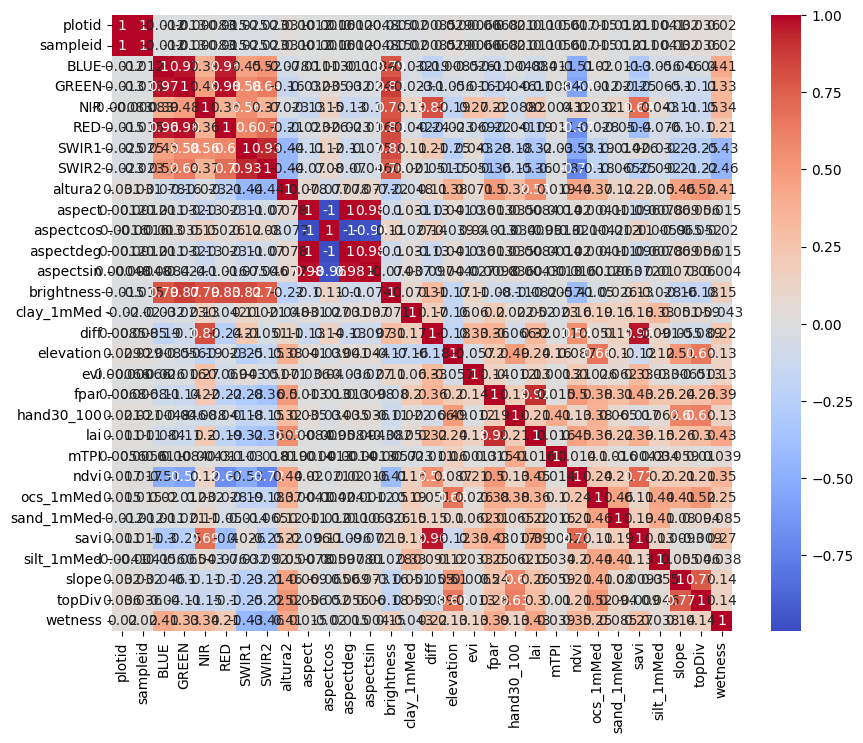

In [69]:
# Correlation Matrix, including with the different % cover values from the 1 point dataframe?
# TODO: Add correlation matrix for % cover values from the 1 point dataframe

predictors = gdf_predictors.select_dtypes(include=['float64', 'int64'])

correlation_matrix = predictors.corr()
#display(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

In [70]:
display(gdf_predictors['Use'].unique())

array(['Wetlands', 'Grasslands', 'Other classes', 'Forest', 'Agriculture',
       'Forest plantation', 'No information', 'Not_Applicable'],
      dtype=object)

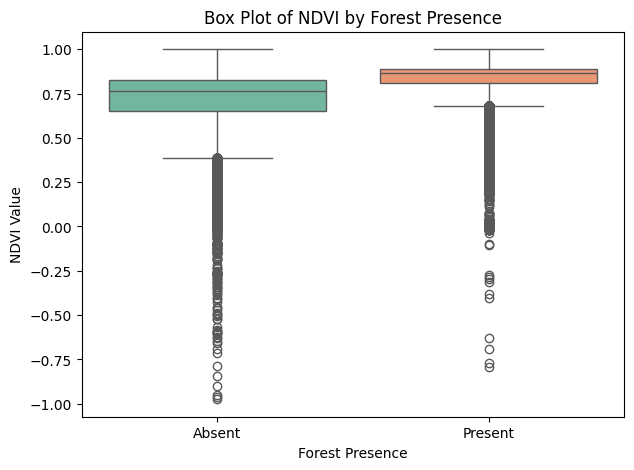

In [71]:
# Create a new column indicating 'Forest Present' or 'Absent'
gdf_predictors['Forest_Presence'] = gdf_predictors['Use'].apply(lambda x: 'Present' if x in ['Forest', 'Pasture ', 'Agriculture', 'Forest Plantation', 'WetLand'] else 'Absent')

# Create Boxplot with fixed palette assignment
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf_predictors, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()

In [72]:
#We are checking all the values that have a absents in forest
absent_use_values = gdf_predictors[gdf_predictors['Forest_Presence'] == 'Absent']['Use']
print(absent_use_values)

9           Wetlands
12        Grasslands
13          Wetlands
15        Grasslands
16          Wetlands
             ...    
101124    Grasslands
101125    Grasslands
101127    Grasslands
101128    Grasslands
101130    Grasslands
Name: Use, Length: 31412, dtype: object


In [73]:
unique_absent_use_values = absent_use_values.unique()
print(unique_absent_use_values)
use_counts = absent_use_values.value_counts()
print(use_counts)

['Wetlands' 'Grasslands' 'Other classes' 'Forest plantation'
 'No information' 'Not_Applicable']
Use
Grasslands           21793
Other classes         4732
Wetlands              3659
Forest plantation      838
No information         219
Not_Applicable         171
Name: count, dtype: int64


In [74]:
high_ndvi_absent = gdf_predictors[(gdf_predictors['Forest_Presence'] == 'Absent') & (gdf_predictors['ndvi'] > 0.33)]

# Group by 'Vegetation' and calculate the mean NDVI
mean_ndvi_by_vegetation = high_ndvi_absent.groupby('Vegetations')['ndvi'].mean()
print(mean_ndvi_by_vegetation)


Vegetations
Herbaceous plants    0.738340
Not_Applicable       0.656511
Other vegetation     0.780386
Palms                0.853307
Shrubs               0.778165
Trees                0.796857
Name: ndvi, dtype: float64


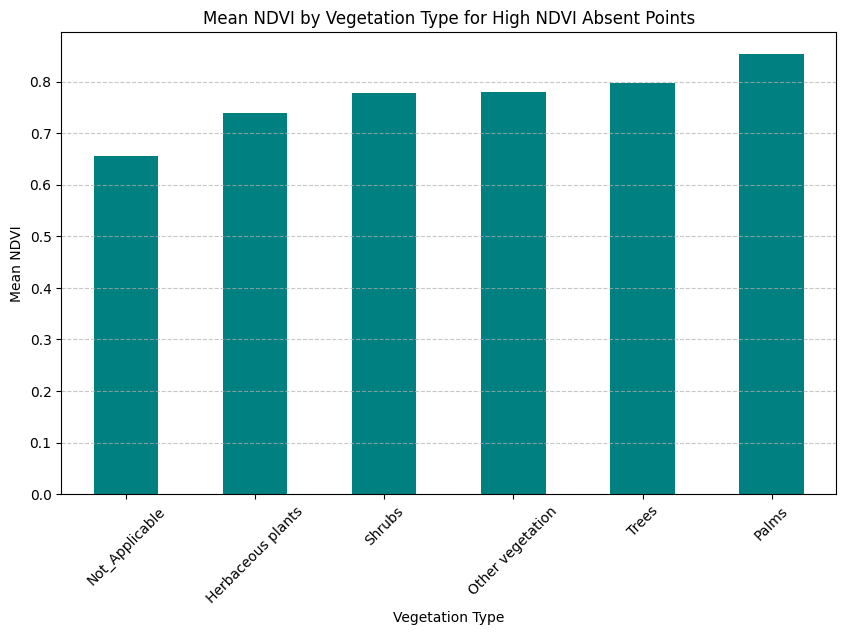

In [75]:
import matplotlib.pyplot as plt

# Filter and group by 'Vegetation', calculating the mean NDVI
high_ndvi_absent = gdf_predictors[(gdf_predictors['Forest_Presence'] == 'Absent') & (gdf_predictors['ndvi'] > 0.33)]
mean_ndvi_by_vegetation = high_ndvi_absent.groupby('Vegetations')['ndvi'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
mean_ndvi_by_vegetation.sort_values().plot(kind='bar', color='teal')

# Customize the plot
plt.xlabel('Vegetation Type')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI by Vegetation Type for High NDVI Absent Points')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [76]:
gdf_predictors.loc[(gdf_predictors['Forest_Presence'] == 'Absent') & (gdf_predictors['ndvi'] > 0.33), 'Forest_Presence'] = 'Present'


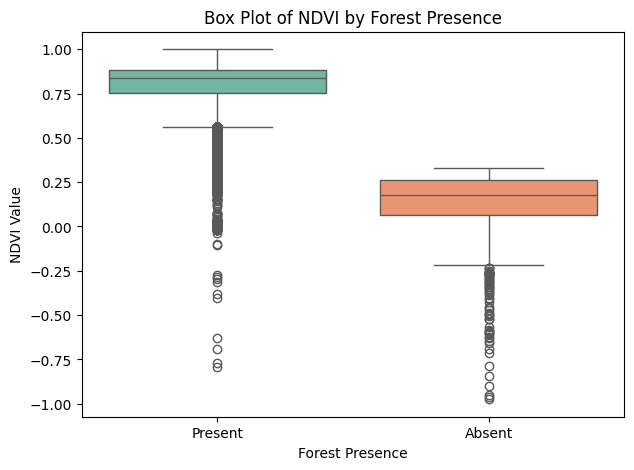

In [77]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf_predictors, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()

In [78]:
q1 = gdf_predictors[gdf_predictors['Forest_Presence'] == 'Present']['ndvi'].quantile(0.25)
q3 = gdf_predictors[gdf_predictors['Forest_Presence'] == 'Present']['ndvi'].quantile(0.75)
iqr = q3 - q1
low_outlier_threshold = q1 - 1.5 * iqr

print(f"Low NDVI Outlier Threshold: {low_outlier_threshold}")


Low NDVI Outlier Threshold: 0.5611601201579609


In [79]:
low_ndvi_outliers = gdf_predictors[(gdf_predictors['Forest_Presence'] == 'Present') & (gdf_predictors['ndvi'] < low_outlier_threshold)]
low_ndvi_outliers


,plotid,sampleid,Use,CoverType,Vegetations,Herbaceous,GrasslandShrub,CropsType,WetlandArea,LandType,...,mTPI,ndvi,ocs_1mMed,sand_1mMed,savi,silt_1mMed,slope,topDiv,wetness,Forest_Presence
18,2903,11609,Other classes,No vegetation,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Other surfaces,...,8132.0,0.528579,63.0,336.45,0.295504,265.70,7.437723,1323.698838,-0.032052,Present
19,2903,11610,Other classes,No vegetation,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Other surfaces,...,8132.0,0.437536,63.0,336.45,0.152839,265.70,2.645458,1323.698838,-0.016620,Present
63,2960,11837,Wetlands,Water,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Water bodies,Not_Applicable,...,8127.0,0.503759,58.0,264.65,0.249684,268.00,3.382467,1323.673565,-0.056526,Present
66,2960,11840,Wetlands,Water,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Water bodies,Not_Applicable,...,8127.0,0.421427,58.0,264.65,0.172648,268.00,0.000000,1323.673565,-0.026745,Present
67,2960,11841,Wetlands,Water,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Water bodies,Not_Applicable,...,8127.0,0.451770,58.0,264.65,0.212015,268.00,0.000000,1323.673565,-0.072998,Present
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101084,906847,3627390,Forest,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,...,8157.0,-0.010946,132.0,321.90,-0.012102,333.90,55.651031,1324.630000,0.455953,Present
101085,906847,3627391,Forest,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,...,8232.0,-0.010758,132.0,323.55,-0.011875,324.50,37.565701,1324.630000,0.467968,Present
101086,906847,3627392,Forest,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,...,8232.0,-0.011036,132.0,321.90,-0.012187,333.90,53.213791,1324.630000,0.462251,Present
101087,906847,3627393,Forest,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,Not_Applicable,...,8157.0,-0.010568,132.0,321.90,-0.011680,333.90,49.832008,1324.630000,0.460804,Present


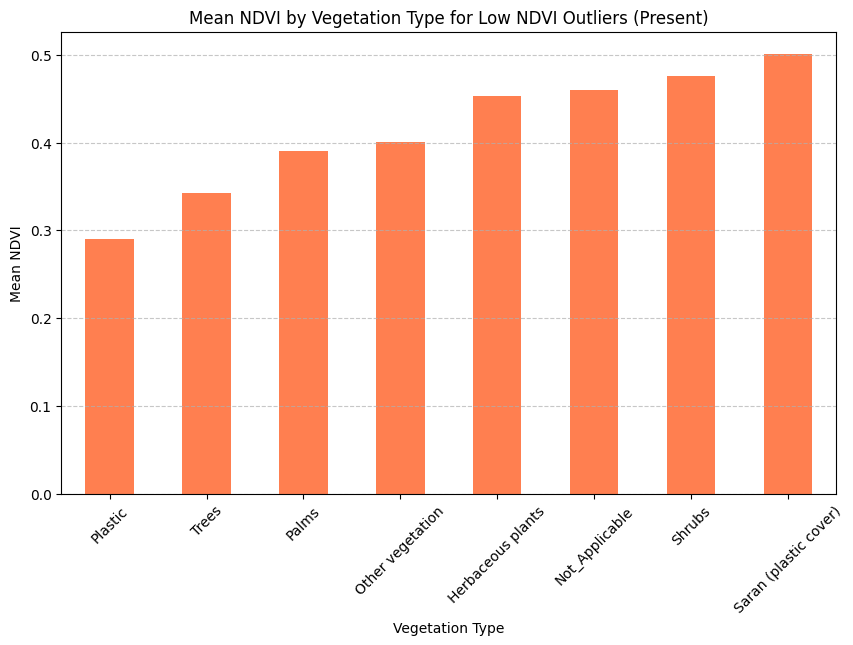

In [80]:
# Step 1: Calculate the IQR and identify low NDVI outliers for 'Present' Forest_Presence
q1 = gdf_predictors[gdf_predictors['Forest_Presence'] == 'Present']['ndvi'].quantile(0.25)
q3 = gdf_predictors[gdf_predictors['Forest_Presence'] == 'Present']['ndvi'].quantile(0.75)
iqr = q3 - q1
low_outlier_threshold = q1 - 1.5 * iqr

# Step 2: Filter the low NDVI outliers
low_ndvi_outliers = gdf_predictors[(gdf_predictors['Forest_Presence'] == 'Present') & (gdf_predictors['ndvi'] < low_outlier_threshold)]

# Step 3: Group by 'Vegetation' and calculate the mean NDVI
mean_ndvi_outliers_by_vegetation = low_ndvi_outliers.groupby('Vegetations')['ndvi'].mean()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
mean_ndvi_outliers_by_vegetation.sort_values().plot(kind='bar', color='coral')

# Customize the plot
plt.xlabel('Vegetation Type')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI by Vegetation Type for Low NDVI Outliers (Present)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [81]:
low_ndvi_outliers.set_crs(epsg=4326, inplace=True)
# Save as Shapefile
low_ndvi_outliers.to_file('../Costa_Rica_Data/Data Acquisition Output/low_ndvi_outliers/low_ndvi_outliers.shp')

/home/goldferret/Documents/projects/ndmn-notebooks/venv/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_22007/1487904217.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  low_ndvi_outliers.to_file('../Costa_Rica_Data/Data Acquisition Output/low_ndvi_outliers/low_ndvi_outliers.shp')
/home/goldferret/Documents/projects/ndmn-notebooks/venv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Vegetations' to 'Vegetation'
  ogr_write(
/home/goldferret/Documents/projects/ndmn-notebooks/venv/lib/python3.13/site-packages/pyogrio/raw.py:723: Runtime

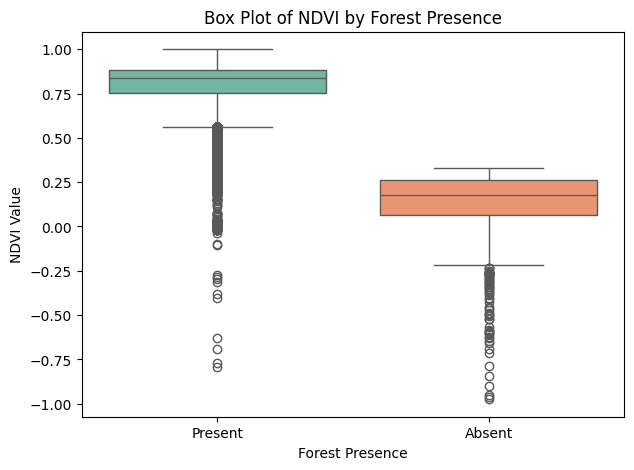

In [82]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf_predictors, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()

In [83]:
len(low_ndvi_outliers)

5546

In [84]:
print(list(gdf_predictors.columns))

['plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss', 'geometry', 'BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'aspect', 'aspectcos', 'aspectdeg', 'aspectsin', 'brightness', 'clay_1mMed', 'diff', 'elevation', 'evi', 'fpar', 'hand30_100', 'lai', 'mTPI', 'ndvi', 'ocs_1mMed', 'sand_1mMed', 'savi', 'silt_1mMed', 'slope', 'topDiv', 'wetness', 'Forest_Presence']


In [85]:
# Update the 'Forest_Presence' column for rows where 'Forest_Presence' is 'Present' and 'ndvi' <= -0.5
gdf_predictors.loc[(gdf_predictors['Forest_Presence'] == 1), 'Forest_Presence'] = 'Present'
gdf_predictors.loc[(gdf_predictors['Forest_Presence'] == 0), 'Forest_Presence'] = 'Absent'
gdf_predictors.head()

,plotid,sampleid,Use,CoverType,Vegetations,Herbaceous,GrasslandShrub,CropsType,WetlandArea,LandType,...,mTPI,ndvi,ocs_1mMed,sand_1mMed,savi,silt_1mMed,slope,topDiv,wetness,Forest_Presence
9,2902,11605,Wetlands,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,8129.0,0.799771,68.0,332.15,0.393728,298.85,0.927410,1323.685053,-0.006312,Present
12,2902,11608,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),Not_Applicable,Not_Applicable,Not_Applicable,...,8129.0,0.796553,68.0,332.15,0.423713,298.85,2.935819,1323.685053,-0.014932,Present
13,2902,11609,Wetlands,Vegetation,Herbaceous plants,Grasses,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,8129.0,0.644415,65.0,340.45,0.380250,304.70,0.944368,1323.685053,-0.001697,Present
15,2902,11611,Grasslands,Vegetation,Herbaceous plants,Grasses,Mixed Pasture (70-90%),Not_Applicable,Not_Applicable,Not_Applicable,...,8129.0,0.784331,68.0,332.15,0.512687,298.85,0.927410,1323.685053,-0.027987,Present
16,2902,11612,Wetlands,Vegetation,Trees,Not_Applicable,Not_Applicable,Not_Applicable,Swamp (Marsh),Not_Applicable,...,8129.0,0.769357,65.0,340.45,0.360428,304.70,2.645556,1323.685053,-0.009912,Present


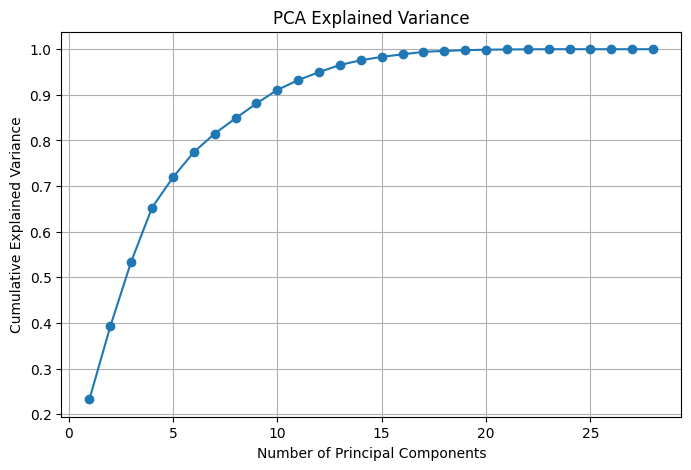

In [86]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
features = gdf_predictors.drop(['Forest_Presence', 'plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss', 'geometry'], axis=1)  # Adjust columns as needed
features_scaled = StandardScaler().fit_transform(features)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(features_scaled)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

In [87]:
# Retain the first 9 or 10 components
n_components = 10  # or 9, depending on how much variance you want to retain
reduced_data = principal_components[:, :n_components]

# Convert it back to a DataFrame for easier handling
reduced_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components)])

# Add your target variable (Forest_Presence) back to the reduced dataset if needed
reduced_df['Forest_Presence'] = gdf_predictors['Forest_Presence'].values

# Show the first few rows of the reduced data
print(reduced_df.head())


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.293332 -1.837715 -1.221866  0.262553  0.759845  1.780217  0.715952   
1 -0.298827 -3.020864  0.753586  1.986402  0.310587  1.303170  0.680551   
2  1.477013 -0.566561 -1.675973 -0.814450  0.721028  1.742934  0.629332   
3  1.606029  1.631651 -3.048346 -0.420528 -0.138250  0.868924  0.487024   
4 -0.496026 -3.593084  0.269709  1.192702  0.636611  1.702571  0.749179   

        PC8       PC9      PC10 Forest_Presence  
0  0.050124  0.164082  0.032083         Present  
1 -0.121381  0.226985 -0.038734         Present  
2 -0.085434  0.293895  0.075413         Present  
3 -0.207749  0.185173 -0.091955         Present  
4 -0.086336  0.361164 -0.057432         Present  


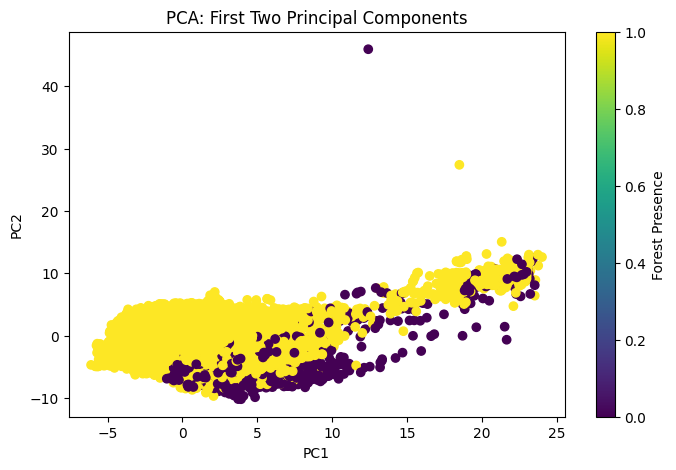

In [88]:
# Visualize the first two principal components
plt.figure(figsize=(8, 5))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], c=reduced_df['Forest_Presence'].map({'Present': 1, 'Absent': 0}), cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First Two Principal Components')
plt.colorbar(label='Forest Presence')
plt.show()

## Saving our Dataframes

In [89]:
# First, check if the change to the Spanish version were saved
na_count = gdf_predictors_sp.isna().sum()
print(na_count)

plotid        0
sampleid      0
Uso           0
Cobertura     0
Vegetacion    0
Herbaceas     0
Pasto_Arb     0
Cultivo       0
Humedal       0
Terreno       0
Agua          0
Otra_clase    0
SAF           0
Cambios15_    0
Gana_Perdi    0
geometry      0
BLUE          0
GREEN         0
NIR           0
RED           0
SWIR1         0
SWIR2         0
altura2       0
aspect        0
aspectcos     0
aspectdeg     0
aspectsin     0
brightness    0
clay_1mMed    0
diff          0
elevation     0
evi           0
fpar          0
hand30_100    0
lai           0
mTPI          0
ndvi          0
ocs_1mMed     0
sand_1mMed    0
savi          0
silt_1mMed    0
slope         0
topDiv        0
wetness       0
dtype: int64


In [90]:
# Now it's time to save them 

# Saves the Spanish (original language) dataframe as a parquet file
gdf_predictors_sp.to_parquet("../Costa_Rica_Data/Data Acquisition Output/extracted_gee_data/sp_clean_gee_data.parquet", engine="pyarrow")

# Saves the English (translated language) dataframe as a parquet file
gdf_predictors.to_parquet("../Costa_Rica_Data/Data Acquisition Output/extracted_gee_data/en_clean_gee_data.parquet", engine="pyarrow")

# Saving the reduced dataframe (English)
reduced_df.to_parquet("../Costa_Rica_Data/Data Acquisition Output/extracted_gee_data/adam_reduced_data.parquet", engine="pyarrow")